# Interactive Galaxy Line Profile Extraction Notebook
C. Stubbs July 2025 with GPT assistance.

This notebook loads an astronomical FITS image, computes a zscale stretch,
displays it interactively using the `ipympl` backend, lets you click two points to define a line,
extracts the flux profile along that line, uses WCS to attach an angular scale,
saves the results as CSV, and plots the (angle, flux) profile.

**Be sure to install `ipympl` (`pip install ipympl`) and run this in a Jupyter environment.**

In [ ]:
!pip install ipympl

Now, **RESTART YOUR KERNE**L.  (Runtime --> Restart Session).

In [ ]:
%matplotlib ipympl

In [ ]:
import numpy as np
import csv
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.wcs import WCS
from skimage.measure import profile_line
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.visualization import ZScaleInterval, ImageNormalize

This next cell will give your notebook access to your Google Drive, and change to your COlab Notebooks folder. That is where it looks for the images we're going to analyze.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir('/content/drive/MyDrive/Astro17_notebooks')

We need a bit of Voodoo to make the interactive displays work

In [ ]:
from google.colab import output
output.enable_custom_widget_manager()

let's appeal to the operating system to list the files that end in .fits, which are our iamges.

M74DSS2red.fits.    gives n~1


In [ ]:
# list avaliable images
!ls *.fits

In [ ]:
# Load the FITS file (update the path as needed)
filename = './M87SDSSr.fits'
hdul = fits.open(filename)
data = hdul[0].data
header = hdul[0].header
wcs = WCS(header)

# Compute zscale interval to get good greyscale image display
interval = ZScaleInterval()
norm = ImageNormalize(data, interval=interval)

In [ ]:
# display the image header, which contains the metadata about the image
header

In [ ]:
# display data values from a 10 x 10 pixel region
data[1:10,1:10]

In [ ]:
# plot flux values for the central row of the image

#import numpy as np
#import matplotlib.pyplot as plt

# Inspect dimensions
print("Data shape:", data.shape)

# Get the number of rows and columns
nrows, ncols = data.shape

# Index of the middle row
mid_row = nrows // 2

# Extract the middle row
row_vals = data[mid_row, :]

# Mask out nonpositive values for the log plot
mask = row_vals > 0
row_vals_pos = row_vals[mask]
cols_pos = np.arange(ncols)[mask]

# Create figure with two vertical subplots
fig, axes = plt.subplots(2, 1, figsize=(8, 8), sharex=True)

# Top panel: linear scale
axes[0].plot(row_vals, marker='o')
axes[0].set_title(f"Middle row (row {mid_row}) - Linear scale")
axes[0].set_ylabel("Value")
axes[0].grid(True)

# Bottom panel: log scale, only positive values
axes[1].plot(cols_pos, row_vals_pos, marker='o')
axes[1].set_yscale("log")
axes[1].set_title(f"Middle row (row {mid_row}) - Log scale (pos only)")
axes[1].set_xlabel("Column index")
axes[1].set_ylabel("Value")
axes[1].grid(True, which="both")

plt.tight_layout()
plt.show()


This next cell will display the image of the galaxy. click on two points to define a line along which we'll plot and fit the brightness profile.

It's best for the first point to be at the center of the galaxy.

Pick a second point that is radially separated, i.e. along a diameter and away from foreground contaminaating stars.


In [ ]:
# %%
# Display image with zscale and WCS
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={'projection': wcs})
im = ax.imshow(data, origin='lower', cmap='gray', norm=norm)
ax.set_xlabel('RA')
ax.set_ylabel('Dec')
plt.title('Click two points to define the profile line')

# Initialize storage for points and profile data
points = []
prof = None
angles_arcsec = None

# %%
# Define click callback for interactive selection
def onclick(event):
    global prof, angles_arcsec
    if event.inaxes != ax:
        return
    x_pix, y_pix = event.xdata, event.ydata
    # Store as (row, col)
    points.append((y_pix, x_pix))
    ax.plot(x_pix, y_pix, 'ro')
    fig.canvas.draw()
    # Once two points are selected, process the profile
    if len(points) == 2:
        fig.canvas.mpl_disconnect(cid)
        # Extract the flux profile along the line
        prof = profile_line(data, points[0], points[1], order=1, mode='reflect')
        n = prof.size
        # Generate intermediate pixel coordinates
        rows = np.linspace(points[0][0], points[1][0], n)
        cols = np.linspace(points[0][1], points[1][1], n)
        # Convert pixel to world coordinates
        world = wcs.pixel_to_world(cols, rows)
        # Reference and separations
        ref = SkyCoord(world.ra[0], world.dec[0])
        angles_arcsec = ref.separation(SkyCoord(world.ra, world.dec)).arcsec
        # Save to CSV
        with open('line_profile.csv', 'w', newline='') as f:
            writer = csv.writer(f)
            writer.writerow(['angle_arcsec', 'flux'])
            for a, fv in zip(angles_arcsec, prof):
                writer.writerow([a, fv])
        print('Saved line_profile.csv')
        # Plot the extracted profile
        plt.figure()
        plt.plot(angles_arcsec, prof)
        plt.xlabel('Angular distance (arcsec)')
        plt.ylabel('Flux')
        plt.title('Extracted Line Profile')
        plt.grid(True)
        plt.show()

# Connect the click event and show the plot
cid = fig.canvas.mpl_connect('button_press_event', onclick)
plt.show()


Repeat the line profile but with log_10 scaling on the vertical axis.

In [ ]:
plt.figure()
plt.plot(angles_arcsec, prof, 'k-')
plt.scatter(angles_arcsec,prof,s=8)
plt.xlabel('Angular distance (arcsec)')
plt.ylabel('Flux')
plt.titleç('Extracted Line Profile')
plt.yscale('log')

plt.grid(True)
plt.show()

# Surface Brightness Profile Fit (Sérsic Law)

Elliptical galaxy profiles are often fit with the Sérsic function:

$$
I(R) = I_e \exp\left[-b_n\left(\left(\frac{R}{R_e}\right)^{1/n} - 1\right)\right]
$$

where:
- $I_e$ is the surface brightness at the effective radius $R_e$.
- $n$ is the Sérsic index (e.g., $n=4$ recovers de Vaucouleurs).
- $b_n$ is a constant such that $\Gamma(2n) = 2\,\gamma(2n,b_n)$, approximated by $b_n \approx 2n - 1/3$.


### Sérsic Profile Parameters

- $I(r)$: Intensity (surface brightness) at radius \(r\).  
- $I_e$: Intensity at the effective radius \(r_e\).  
- $r_e$: The **effective radius**, enclosing half of the galaxy’s total light.  
- $n$: The **Sérsic index**, which controls the shape of the profile.  
- $b_n$: A constant that ensures \(r_e\) really encloses half the light.  
  - Depends on $n$, with an approximate relation:  
    $$
    b_n \approx 2n - \tfrac{1}{3}, \quad (n \gtrsim 1)
    $$

---

### Meaning of the Parameters

**$I_e$: Effective intensity**  
- The surface brightness at the effective radius \(r_e\).  
- Sets the normalization of the brightness profile.  

**$r_e$: Effective radius**  
- The radius enclosing half the total light of the galaxy.  
- Physically characterizes the galaxy’s size.  

**$n$: Sérsic index**  
- Controls the **concentration** of light:  
  - \(n=1\): Exponential profile — typical of disk galaxies.  
  - \(n=4\): de Vaucouleurs profile — typical of elliptical galaxies and bulges.  
  - Larger \(n\): more centrally concentrated, with extended outer wings.  
  - Smaller \(n\): flatter, less centrally concentrated.  

**$b_n$: Normalization constant**  
- Ensures that half the light is within $r_e$.  
- No direct physical meaning on its own, but mathematically tied to $n$.  

---

###  Physical Intuition and Interpretation

- **Disks**: Light falls off roughly exponentially with radius $(n \sim 1)$, so they are less concentrated.  
- **Ellipticals / Bulges**: More concentrated centers with extended outer wings, well fit by higher $n$ values $(n \sim 4{-}10$).  
- **Dwarf ellipticals**: Often have $n < 2$.  
- **Giant ellipticals**: Can have $n > 4$.  

Thus, the Sérsic index \(n\) encodes **galaxy morphology and formation history**:  
- **Low $n$:** Systems dominated by dissipative processes (e.g., star-forming disks).  
- **High $n$:** Systems shaped by mergers and violent relaxation.

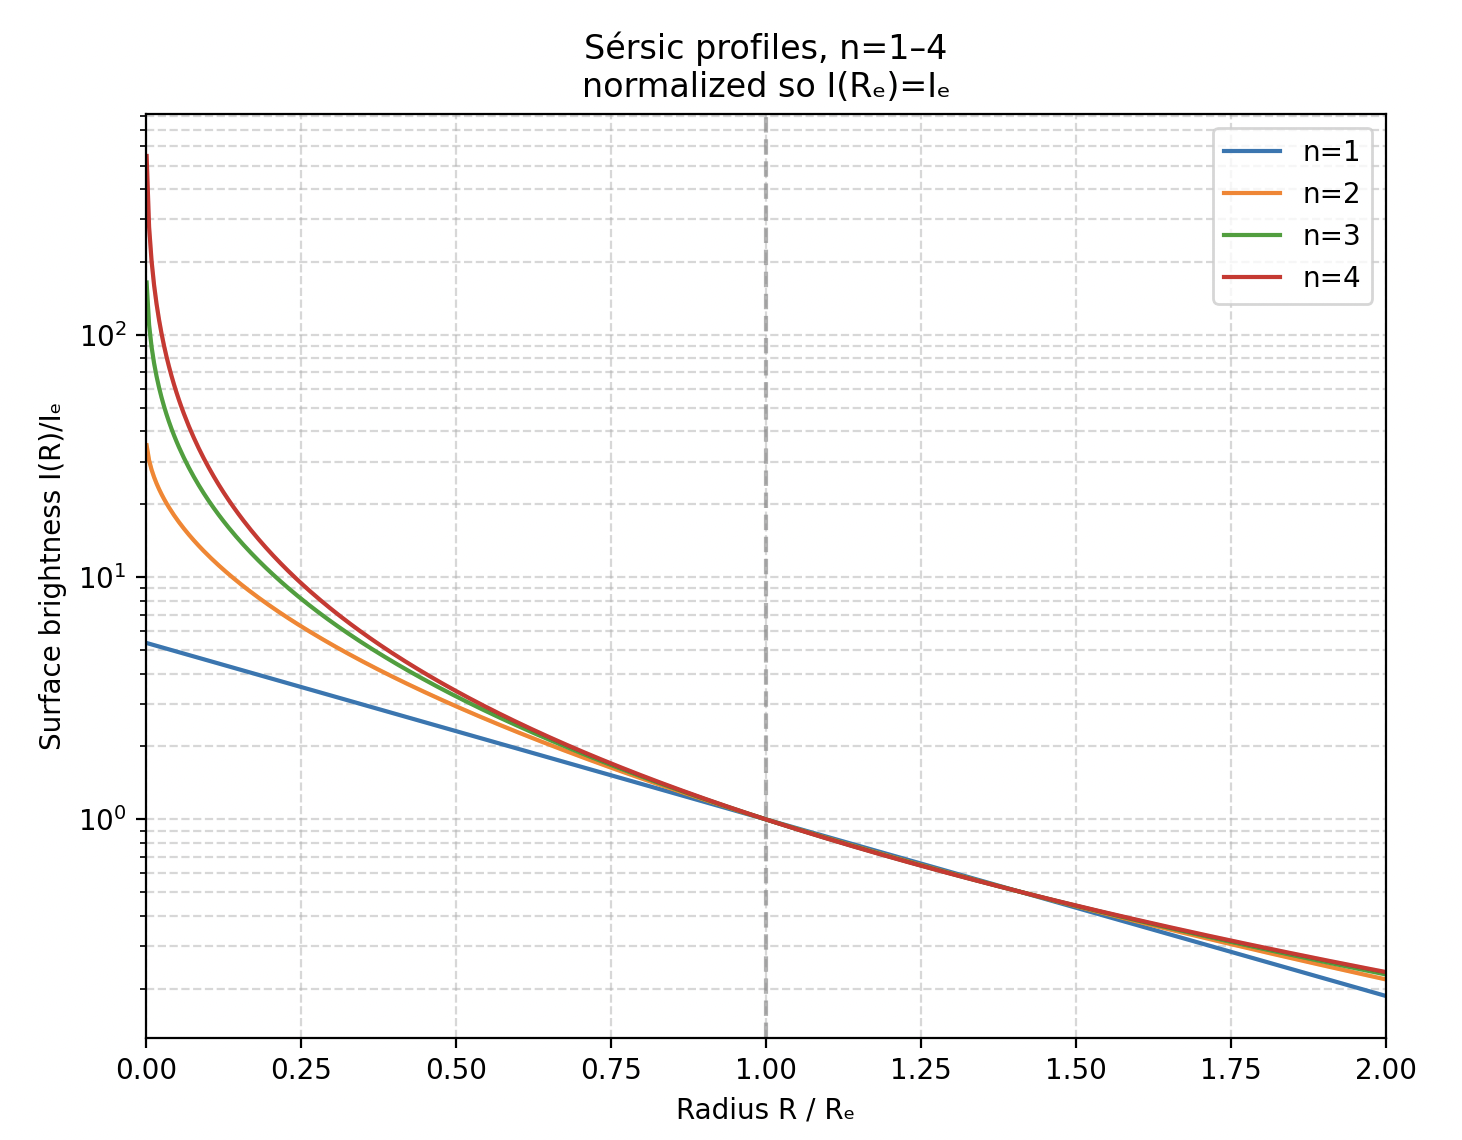


The next cell takes this line profile and does a fit to the Sersic function.

The free parameters are $R_e$, the half-light radius, $I_e$, the central surface brightness, and the concentration parameter $n$

In [ ]:
from scipy.optimize import curve_fit

# Define the Sérsic model
def sersic(R, I_e, R_e, n):
    b_n = 2*n - 1/3
    return I_e * np.exp(-b_n * ((R / R_e)**(1/n) - 1))

# Check data availability
if prof is None or angles_arcsec is None:
    raise RuntimeError("No profile data: please run the selection cell first.")

# Filter positive flux values
mask = prof > 0
R = angles_arcsec[mask]
I = prof[mask]

# Initial guesses: I_e ~ max(I), R_e ~ median(R), n ~ 4
p0 = [I.max(), np.median(R), 4.0]

# Perform the fit
popt, pcov = curve_fit(sersic, R, I, p0=p0, bounds=([0,0,0.5],[np.inf,np.inf,10]))
I_e_fit, R_e_fit, n_fit = popt
print(f"Fitted parameters: I_e = {I_e_fit:.3e}, R_e = {R_e_fit:.3f} arcsec, n = {n_fit:.2f}")

# Plot data and model
import matplotlib.pyplot as plt
plt.figure(figsize=(6,4))
plt.scatter(R, I, s=5, label='Data')
R_fit = np.linspace(R.min(), R.max(), 200)
plt.plot(R_fit, sersic(R_fit, *popt), 'r-', label=f'Sérsic fit (n={n_fit:.2f})')
plt.yscale('log')
plt.xlabel('R (arcsec)')
plt.ylabel('Flux')
plt.title('Sérsic Profile Fit')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# add constant for sky background.

%%markdown

## Sérsic Surface Brightness Profile Fit with Sky Background

We now include a constant background term $I_b$:

$$
I(R) = I_b + I_e \exp\Bigl[-b_n((R/R_e)^{1/n}-1)\Bigr],
\quad b_n\approx2n-\tfrac13.
$$

Fit $I_e$, $R_e$, $n$, and $I_b$ using non-linear least squares.

In [ ]:
def sersic_offset(R, I_e, R_e, n, I_b):
    b_n = 2*n - 1/3
    return I_b + I_e * np.exp(-b_n * ((R/R_e)**(1/n) - 1))

# Ensure profile exists
if prof is None or angles_arcsec is None:
    raise RuntimeError('Run the click-selection cell first')

# Select valid data points
mask = prof > 0
R = angles_arcsec[mask]
I = prof[mask]

# Initial parameter guesses
I_b0 = np.min(I)
I_e0 = np.max(I) - I_b0
R_e0 = np.median(R)
n0 = 4.0
p0 = [I_e0, R_e0, n0, I_b0]

# Bounds: I_e>0, R_e>0, 0.5<n<10, I_b>=0
bounds = ([0, 0, 0.5, 0], [np.inf, np.inf, 10, np.inf])

# Fit model
theta, cov = curve_fit(sersic_offset, R, I, p0=p0, bounds=bounds)
I_e_fit, R_e_fit, n_fit, I_b_fit = theta
print(f"Fitted parameters:\n  I_e = {I_e_fit:.3e}\n  R_e = {R_e_fit:.3f} arcsec\n  n   = {n_fit:.2f}\n  I_b = {I_b_fit:.3e}")

# Plot data and best-fit model
R_fit = np.linspace(R.min(), R.max(), 200)
model = sersic_offset(R_fit, *theta)
plt.figure(figsize=(6,4))
plt.scatter(R, I, s=5, label='Data')
plt.plot(R_fit, model, 'r-', label=f'Sérsic+bg (n={n_fit:.2f})')
plt.yscale('log')
plt.xlabel('R (arcsec)')
plt.ylabel('Flux')
plt.title('Sérsic Profile Fit with Background')
plt.legend()
plt.grid(True)
plt.show()